# Introduction

This notebook will illustrate experiments with the Adam optimizer in TensorFlow to solve the `lagaris_05` 2-D PDE BVP.

## The `lagaris_05` PDE problem

This PDE was used as the fifth example problem in (Lagaris *et al.*, 1998). The differential equation is provided in the form (equation (32) in Lagaris *et al.* (1998)):

\begin{equation}
    \nabla^2 \psi (x,y) = e^{-x} \left( x - 2 + y^3 + 6y \right)
\end{equation}

or:

\begin{equation}
    G \left( x, y, \psi, \frac {\partial \psi} {dx}, \frac {\partial \psi} {\partial y}, \frac {\partial^2 \psi} {dx^2} \frac {\partial^2 \psi} {\partial y^2} \right) = \frac {\partial^2 \psi} {\partial x^2} + \frac {\partial^2 \psi} {dy^2} - e^{-x} \left( x - 2 + y^3 + 6y \right) = 0
\end{equation}

with initial conditions:

\begin{equation}
    f_0(0, y) = \psi(0, y) = y^3 \\
    f_1(1, y) = \psi(1, y) = ( 1 + y^3 ) e^{-1} \\
    g_0(x, 0) = \psi(x, 0) = x e^{-x} \\
    g_1(x, 1) = \psi(x, 1) = e^{-x} (x + 1)
\end{equation}

The analytical solution is:

\begin{equation}
    \psi_a(x, y) = e^{-x} (x + y^3)
\end{equation}

The 1st and 2nd partial derivatives are:

\begin{equation}
    \frac {\partial \psi} {\partial x} = e^{-x} ( 1 - x - y^3) \\
    \frac {\partial \psi} {\partial y} = 3 e^{-x} y^2 \\
    \frac {\partial^2 \psi} {\partial x^2} = e^{-x} ( -2 + x + y^3) \\
    \frac {\partial^2 \psi} {\partial y^2} = 6 e^{-x} y
\end{equation}

The analytical solution in the domain $0 \leq x,y \leq 1$ is plotted below.

In [1]:
# Import standard Python modules.
import datetime
import importlib
from itertools import repeat
from math import exp
import os
import platform
import sys

# Import 3rd-party modules.
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Import TensorFlow.
import tensorflow as tf

In [2]:
# Use 64-bit math in TensorFlow.
tf.keras.backend.set_floatx('float64')

In [3]:
# Import the problem definition.
eq_name = "lagaris_05"
eq_module = 'nnde.differentialequation.examples.lagaris_05'
eq = importlib.import_module(eq_module)

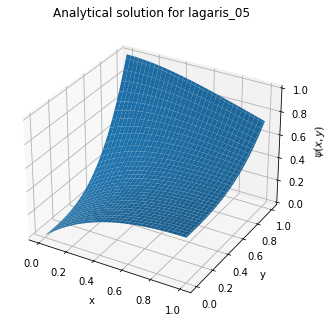

In [4]:
# Compute the analytical solution.
na = 101
xa = np.linspace(0, 1, na)
ya = np.linspace(0, 1, na)
Ya = [[eq.Ya([x, y]) for y in ya] for x in xa]
Ya = np.array(Ya)

# Plot the analytical solution.
fig = plt.figure()
(X, Y) = np.meshgrid(xa, ya)
Z = Ya.T
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
ax.plot_surface(X, Y, Z)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('$\psi(x,y)$')
plt.title("Analytical solution for %s" % eq_name)
plt.show()

## Solving `lagaris_05` using TensorFlow

In [5]:
def print_system_information():
    print("System report:")
    print(datetime.datetime.now())
    print("Host name: %s" % platform.node())
    print("OS: %s" % platform.platform())
    print("uname:", platform.uname())
    print("Python version: %s" % sys.version)
    print("Python build:", platform.python_build())
    print("Python compiler: %s" % platform.python_compiler())
    print("Python implementation: %s" % platform.python_implementation())
    # print("Python file: %s" % __file__)

In [6]:
def create_output_directory(path=None):
    path_noext, ext = os.path.splitext(path)
    output_dir = path_noext
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    return output_dir

In [7]:
from nnde.math.trainingdata import create_training_grid2

def create_training_data(*n_train):
    x_train = np.array(create_training_grid2(*n_train))
    return x_train

In [8]:
def build_model(H, w0_range, u0_range, v0_range):
    hidden_layer = tf.keras.layers.Dense(
        units=H, use_bias=True,
        activation=tf.keras.activations.sigmoid,
        # activation=tf.keras.activations.linear,
        kernel_initializer=tf.keras.initializers.RandomUniform(*w0_range),
        bias_initializer=tf.keras.initializers.RandomUniform(*u0_range)
    )
    output_layer = tf.keras.layers.Dense(
        units=1,
        activation=tf.keras.activations.linear,
        kernel_initializer=tf.keras.initializers.RandomUniform(*v0_range),
        use_bias=False,
    )
    model = tf.keras.Sequential([hidden_layer, output_layer])
    return model

In [9]:
print_system_information()

System report:
2021-12-03 10:42:18.622342
Host name: C02DT5CZMD6T-ML
OS: macOS-10.16-x86_64-i386-64bit
uname: uname_result(system='Darwin', node='C02DT5CZMD6T-ML', release='20.6.0', version='Darwin Kernel Version 20.6.0: Mon Aug 30 06:12:21 PDT 2021; root:xnu-7195.141.6~3/RELEASE_X86_64', machine='x86_64', processor='i386')
Python version: 3.8.12 (default, Oct 12 2021, 06:23:56) 
[Clang 10.0.0 ]
Python build: ('default', 'Oct 12 2021 06:23:56')
Python compiler: Clang 10.0.0 
Python implementation: CPython


In [10]:
# Set up the output directory.
path = "./lagaris_05"
output_dir = create_output_directory(path)

In [189]:
# Define the hyperparameters.

# Training optimizer
training_algorithm = "Adam"

# Initial parameter ranges
w0_range = [-0.1, 0.1]
u0_range = [-0.1, 0.1]
v0_range = [-0.1, 0.1]

# Maximum number of training epochs.
max_epochs = 1000

# Learning rate.
learning_rate = 0.01

# Relative tolerance for consecutive loss function values to indicate convergence.
tol = 1e-6

# Number of hidden nodes.
H = 10

# Number of training points in each dimension.
nx_train = 11
ny_train = 11
n_train = nx_train*ny_train

# Random number generator seed.
random_seed = 0

In [190]:
# Create and save the training data.
xy_train = create_training_data(nx_train, ny_train)
x_train = xy_train[::ny_train, 0]
y_train = xy_train[:ny_train, 1]
np.savetxt(os.path.join(output_dir,'xy_train.dat'), xy_train)

In [191]:
# Define the form of the trial solution.

# Precompute constants.
c1 = exp(-1)

def Y_trial(xy, N):
    x = xy[:, 0]
    y = xy[:, 1]
    A = (
        (1 - x)*y**3
        + x*(1 + y**3)*c1
        + (1 - y)*x*(tf.math.exp(-x) - c1)
        + y*(tf.math.exp(-x)*(x + 1) - (1 - x + 2*x*c1))
    )
    P = x*(1 - x)*y*(1 - y)
    Y = A + P*N[:, 0]
    return Y

In [193]:
# Build the model.
model = build_model(H, w0_range, u0_range, v0_range)

# Create the optimizer.
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Train the model.

# Create history variables.
losses = []
phist = []

# Set the random number seed for reproducibility.
tf.random.set_seed(random_seed)

# Rename the training data Variable (_v) for convenience, just for training.
xy_train_v = tf.Variable(xy_train, name="xy_train")
xy = xy_train_v

# Clear the convergence flag to start.
converged = False

# Precompute constants.
c1 = exp(-1)

# This small identity matrix is used during the computation of
# some of the derivatives below.
m = 2
kd = np.identity(m)[np.newaxis, :, :, np.newaxis]
n = n_train

# print("Hyperparameters: n_train = %s, H = %s, max_epochs = %s, learning_rate = %s"
#       % (n_train, H, max_epochs, learning_rate))
# t_start = datetime.datetime.now()
# print("Training started at", t_start)

for epoch in range(max_epochs):

    # Run the forward pass.
    with tf.GradientTape(persistent=True) as tape3:
        with tf.GradientTape(persistent=True) as tape2:
            with tf.GradientTape(persistent=True) as tape1:

                # Extract individual variables for convenience.
                x = xy[:, 0]
                y = xy[:, 1]
                # print("x = %s" % x.numpy())
                # print("y = %s" % y.numpy())

                # Compute the network output.
                N = model(xy)
                # print("N = %s" % N.numpy())
                ##########
                # <HACK>
                w = model.trainable_variables[0].numpy()
                u = model.trainable_variables[1].numpy()
                v = model.trainable_variables[2].numpy().reshape((H,))
                # </HACK>
                ##########

                ##########
                # <HACK>
                z = xy@model.trainable_variables[0] + model.trainable_variables[1]
                # print("z = %s" % z)
                s = tf.keras.activations.sigmoid(z)
                # print("s = %s" % s)
                s1 = tape1.gradient(s, z)
                # print("s1 = %s" % s1)
                s2 = tape1.gradient(s1, z)
                # print("s2 = %s" % s2)
                s3 = tape1.gradient(s2, z)
                # print("s2 = %s" % s3)
                s = s.numpy()
                s1 = s1.numpy()
                s2 = s2.numpy()
                s3 = s3.numpy()
                # </HACK>
                ##########

                # Compute the trial solution.
                A = (
                    (1 - x)*y**3
                    + x*(1 + y**3)*c1
                    + (1 - y)*x*(tf.math.exp(-x) - c1)
                    + y*(tf.math.exp(-x)*(x + 1) - (1 - x + 2*x*c1))
                )
                P = x*(1 - x)*y*(1 - y)
                Y = A + P*N[:, 0]
                # print("Y = %s" % Y.numpy())

            #######
            # <HACK>
            delN = tape1.gradient(N, xy)
            # print("delN = %s" % delN)
            dN_dw = v*s1[:, np.newaxis, :]*xy.numpy()[:, :, np.newaxis]
            # print("dN_dw = %s" % dN_dw)
            dN_du = v*s1
            # print("dN_du = %s" % dN_du)
            dN_dv = s
            # print("dN_dv = %s" % dN_dv)
            delP = tape1.gradient(P, xy)
            # print("delP = %s" % delP)
            delYt = np.vstack([dY_dx.numpy(), dY_dy.numpy()]).T
            # print("delYt = %s" % delYt)
            dYt_dw = P[:, np.newaxis, np.newaxis]*dN_dw
            # print("dYt_dw = %s" % dYt_dw)
            dYt_du = P[:, np.newaxis]*dN_du
            # print("dYt_du = %s" % dYt_du)
            dYt_dv = P[:, np.newaxis]*dN_dv
            # print("dYt_dv = %s" % dYt_dv)
            # </HACK>
            #######

            # Compute the gradient of the trial solution wrt inputs.
            dY_dx = tape1.gradient(Y, x)
            # print("dY_dx = %s" % dY_dx.numpy())
            dY_dy = tape1.gradient(Y, y)
            # print("dY_dy = %s" % dY_dy.numpy())

        #######
        # <HACK>
        del2N = s2.dot((w**2*v).T)
        # print("del2N = %s" % del2N)
        d2N_dwdx = (v[np.newaxis, np.newaxis, np.newaxis, :]
                    * (s1[:, np.newaxis, np.newaxis, :]*kd
                       + s2[:, np.newaxis, np.newaxis, :]
                       * w[np.newaxis, np.newaxis, :, :]
                       * xy.numpy()[:, :, np.newaxis, np.newaxis]))
        # print("d2N_dwdx = %s" % d2N_dwdx)
        d2N_dudx = v*s2[:, np.newaxis, :]*w[np.newaxis, :, :]
        # print("d2N_dudx = %s" % d2N_dudx)
        d2N_dvdx = s1[:, np.newaxis, :]*w[np.newaxis, :, :]
        # print("d2N_dvdx = %s" % d2N_dvdx)
        del2P = np.zeros((n, m))
        for i in range(n):
            del2P[i, 0] = -2*y.numpy()[i]*(1 - y.numpy()[i])
            del2P[i, 1] = x.numpy()[i]*(1 - x.numpy()[i])*-2
        # print("del2P = %s" % del2P)
        del2Yt = np.vstack([d2Y_dx2.numpy(), d2Y_dy2.numpy()]).T
        # print("del2Yt = %s" % del2Yt)
        d2Yt_dwdx = (P[:, np.newaxis, np.newaxis, np.newaxis]*d2N_dwdx
                     + delP[:, np.newaxis, :, np.newaxis]
                     * dN_dw[:, :, np.newaxis, :])
        # print("d2Yt_dwdx = %s" % d2Yt_dwdx)
        d2Yt_dudx = (P[:, np.newaxis, np.newaxis]*d2N_dudx
                     + delP[:, :, np.newaxis]*dN_du[:, np.newaxis, :])
        # print("d2Yt_dudx = %s" % d2Yt_dudx)
        d2Yt_dvdx = (P[:, np.newaxis, np.newaxis]*d2N_dvdx
                     + delP[:, :, np.newaxis]*dN_dv[:, np.newaxis, :])
        # print("d2Yt_dvdx = %s" % d2Yt_dvdx)
        # </HACK>
        #######

        # Compute the Laplacian of trial solution wrt inputs.
        d2Y_dx2 = tape2.gradient(dY_dx, x)
        # print("d2Y_dx2 = %s" % d2Y_dx2.numpy())
        d2Y_dy2 = tape2.gradient(dY_dy, y)
        # print("d2Y_dy2 = %s" % d2Y_dy2.numpy())

        # Compute the estimates of the differential equation.
        G = d2Y_dx2 + d2Y_dy2 - tf.math.exp(-x)*(x - 2 + y**3 + 6*y)
        # print("G = %s" % G.numpy())

        # Compute the loss function.
        L = tf.reduce_sum(G**2)
        # print("L = %s" % L.numpy())

    # Save the current loss.
    losses.append(L.numpy())

    ##########
    # <HACK>
    d3N_dwdx2 = (v[np.newaxis, np.newaxis, np.newaxis, :]
                 * (2*s2[:, np.newaxis, np.newaxis, :]
                    * w[np.newaxis, np.newaxis, :, :]*kd
                    + s3[:, np.newaxis, np.newaxis, :]
                    * w[np.newaxis, :, np.newaxis, :]**2
                    * xy.numpy()[:, :, np.newaxis, np.newaxis]))
    # print("d3N_dwdx2 = %s" % d3N_dwdx2)
    d3N_dudx2 = v*s3[:, np.newaxis, :]*w[np.newaxis, :, :]**2
    # print("d3N_dudx2 = %s" % d3N_dudx2)
    d3N_dvdx2 = s2[:, np.newaxis, :]*w[np.newaxis, :, :]**2
    # print("d3N_dvdx2 = %s" % d3N_dvdx2)
    d3Yt_dwdx2 = (P[:, np.newaxis, np.newaxis, np.newaxis]*d3N_dwdx2
                  + 2*delP[:, np.newaxis, :, np.newaxis]*d2N_dwdx
                  + del2P[:, np.newaxis, :, np.newaxis]
                  * dN_dw[:, :, np.newaxis, :])
    # print("d3Yt_dwdx2 = %s" % d3Yt_dwdx2)
    d3Yt_dudx2 = (P[:, np.newaxis, np.newaxis]*d3N_dudx2
                  + 2*delP[:, :, np.newaxis]*d2N_dudx
                  + del2P[:, :, np.newaxis]*dN_du[:, np.newaxis, :])
    # print("d3Yt_dudx2 = %s" % d3Yt_dudx2)
    d3Yt_dvdx2 = (P[:, np.newaxis, np.newaxis]*d3N_dvdx2
                  + 2*delP[:, :, np.newaxis]*d2N_dvdx
                  + del2P[:, :, np.newaxis]*dN_dv[:, np.newaxis, :])
    # print("d3Yt_dvdx2 = %s" % d3Yt_dvdx2)
    dG_dYt = np.zeros(n)
    dG_ddelYt = np.zeros((n, m))
    dG_ddel2Yt = np.zeros((n, m))
    for i in range(n):
        dG_dYt[i] = 0
        for j in range(m):
            dG_ddelYt[i, j] = 0
            dG_ddel2Yt[i, j] = 1
    dG_dw = (dG_dYt[:, np.newaxis, np.newaxis]*dYt_dw).numpy()
    for i in range(n):
        for j in range(m):
            for k in range(H):
                for jj in range(m):
                    dG_dw[i, j, k] += \
                        dG_ddelYt[i, jj]*d2Yt_dwdx[i, j, jj, k] + \
                        dG_ddel2Yt[i, jj]*d3Yt_dwdx2[i, j, jj, k]
    # print("dG_dw = %s" % dG_dw)
    dG_du = (dG_dYt[:, np.newaxis]*dYt_du).numpy()
    for i in range(n):
        for k in range(H):
            for j in range(m):
                dG_du[i, k] += \
                    dG_ddelYt[i, j]*d2Yt_dudx[i, j, k] + \
                    dG_ddel2Yt[i, j]*d3Yt_dudx2[i, j, k]
    # print("dG_du = %s" % dG_du)
    dG_dv = (dG_dYt[:, np.newaxis]*dYt_dv).numpy()
    for i in range(n):
        for k in range(H):
            for j in range(m):
                dG_dv[i, k] += \
                    dG_ddelYt[i, j]*d2Yt_dvdx[i, j, k] + \
                    dG_ddel2Yt[i, j]*d3Yt_dvdx2[i, j, k]
    # print("dG_dv = %s" % dG_dv)
    # </HACK>
    ##########

    # Check for convergence.
    if epoch > 0:
        loss_delta = (losses[-1] - losses[-2])/losses[-2]
        if abs(loss_delta) <= tol:
            converged = True
            break

    # Compute the gradient of the loss function wrt the network parameters.
    # pgrad = tape3.gradient(L, model.trainable_variables)
    # pjac = tape3.jacobian(L, model.trainable_variables)
    
    ##########
    # <HACK>
    dL_dw = np.zeros((m, H))
    for j in range(m):
        for k in range(H):
            for i in range(n):
                dL_dw[j, k] += 2*G[i]*dG_dw[i, j, k]
    # print("dL_dw = %s" % dL_dw)
    dL_du = np.zeros(H)
    for k in range(H):
        for i in range(n):
            dL_du[k] += 2*G[i]*dG_du[i, k]
    # print("dL_du = %s" % dL_du)
    dL_dv = np.zeros(H)
    for k in range(H):
        for i in range(n):
            dL_dv[k] += 2*G[i]*dG_dv[i, k]
    # print("dL_dv = %s" % dL_dv)
    pgrad = [None, None, None]
    pgrad[0] = tf.convert_to_tensor(dL_dw)
    pgrad[1] = tf.convert_to_tensor(dL_du)
    pgrad[2] = tf.convert_to_tensor(dL_dv[:, np.newaxis])
    # print("pgrad = %s" % pgrad)
    # </HACK>
    ##########

    # Save the parameters used in this epoch.
    phist.append(
        np.hstack(
            (model.trainable_variables[0].numpy().reshape((2*H,)),    # w (2, H) matrix -> (2H,) row vector
             model.trainable_variables[1].numpy(),       # u (H,) row vector
             model.trainable_variables[2][:, 0].numpy()) # v (H, 1) column vector
        )
    )

    # Update the parameters for this epoch.
    optimizer.apply_gradients(zip(pgrad, model.trainable_variables))

    # if epoch % 100 == 0:
    print("Ending epoch %s, loss function = %s" % (epoch, L.numpy()))

# Save the parameters used in the last epoch.
phist.append(
    np.hstack(
        (model.trainable_variables[0].numpy().reshape((2*H,)),    # w (2, H) matrix -> (2H,) row vector
         model.trainable_variables[1].numpy(),       # u (H,) row vector
         model.trainable_variables[2][:, 0].numpy()) # v (H, 1) column vector
    )
)

print("Epochs: %d" % (epoch + 1))
print("Final value of loss function: %f" % losses[-1])
print("converged = %s" % converged)

# Save the parameter histories.
np.savetxt(os.path.join(output_dir, 'phist.dat'), np.array(phist))

Ending epoch 0, loss function = 8.538958928628483
Ending epoch 1, loss function = 6.768611420303751
Ending epoch 2, loss function = 5.27402938771989
Ending epoch 3, loss function = 4.065865165666994
Ending epoch 4, loss function = 3.149281530665883
Ending epoch 5, loss function = 2.5207340236083695
Ending epoch 6, loss function = 2.1635984478661
Ending epoch 7, loss function = 2.0428987644136045
Ending epoch 8, loss function = 2.1031040221042234
Ending epoch 9, loss function = 2.2739219008170446
Ending epoch 10, loss function = 2.4819068496123333
Ending epoch 11, loss function = 2.664429869825201
Ending epoch 12, loss function = 2.780388745224305
Ending epoch 13, loss function = 2.813048119785001
Ending epoch 14, loss function = 2.766086162472489
Ending epoch 15, loss function = 2.656632282927682
Ending epoch 16, loss function = 2.5083058556204825
Ending epoch 17, loss function = 2.3456523578175323
Ending epoch 18, loss function = 2.1902634115925395
Ending epoch 19, loss function = 2.0

In [194]:
# Compute and save the trained results at training points.
with tf.GradientTape(persistent=True) as tape2:
    with tf.GradientTape(persistent=True) as tape1:
        x = xy[:, 0]
        y = xy[:, 1]
        N = model(xy)
        A = (
            (1 - x)*y**3
            + x*(1 + y**3)*c1
            + (1 - y)*x*(tf.math.exp(-x) - c1)
            + y*(tf.math.exp(-x)*(x + 1) - (1 - x + 2*x*c1))
        )
        P = x*(1 - x)*y*(1 - y)
        # Solution.
        Yt_train = A + P*N[:, 0]
    # First partial derivatives.
    dYt_dx_train = tape1.gradient(Yt_train, x)
    dYt_dy_train = tape1.gradient(Yt_train, y)
# Second partial derivatives.
d2Yt_dx2_train = tape2.gradient(dYt_dx_train, x)
d2Yt_dy2_train = tape2.gradient(dYt_dy_train, y)
np.savetxt(os.path.join(output_dir, 'Yt_train.dat'), Yt_train.numpy().reshape((n_train)))
np.savetxt(os.path.join(output_dir, 'dYt_dx_train.dat'), dYt_dx_train.numpy())
np.savetxt(os.path.join(output_dir, 'dYt_dy_train.dat'), dYt_dy_train.numpy())
np.savetxt(os.path.join(output_dir, 'd2Yt_dx2_train.dat'), d2Yt_dx2_train.numpy())
np.savetxt(os.path.join(output_dir, 'd2Yt_dy2_train.dat'), d2Yt_dy2_train.numpy())

# Compute and save the analytical solution and derivatives at training points.
Ya_train = np.array([eq.Ya(xy) for xy in xy_train])
np.savetxt(os.path.join(output_dir,'Ya_train.dat'), Ya_train)
dYa_dx_train = np.array([eq.dYa_dx(xy) for xy in xy_train])
dYa_dy_train = np.array([eq.dYa_dy(xy) for xy in xy_train])
np.savetxt(os.path.join(output_dir,'dYa_dx_train.dat'), dYa_dx_train)
np.savetxt(os.path.join(output_dir,'dYa_dy_train.dat'), dYa_dy_train)
d2Ya_dx2_train = np.array([eq.d2Ya_dx2(xy) for xy in xy_train])
d2Ya_dy2_train = np.array([eq.d2Ya_dy2(xy) for xy in xy_train])
np.savetxt(os.path.join(output_dir,'d2Ya_dx2_train.dat'), d2Ya_dx2_train)
np.savetxt(os.path.join(output_dir,'d2Ya_dy2_train.dat'), d2Ya_dy2_train)

# Compute and save the error in the trained solution and derivatives at training points.
Yt_err_train = Yt_train.numpy() - Ya_train
np.savetxt(os.path.join(output_dir, 'Yt_err_train.dat'), Yt_err_train)
dYt_dx_err_train = dYt_dx_train.numpy() - dYa_dx_train
dYt_dy_err_train = dYt_dx_train.numpy() - dYa_dy_train
np.savetxt(os.path.join(output_dir, 'dYt_dx_err_train.dat'), dYt_dx_err_train)
np.savetxt(os.path.join(output_dir, 'dYt_dy_err_train.dat'), dYt_dy_err_train)
d2Yt_dx2_err_train = d2Yt_dx2_train.numpy() - d2Ya_dx2_train
d2Yt_dy2_err_train = d2Yt_dx2_train.numpy() - d2Ya_dy2_train
np.savetxt(os.path.join(output_dir, 'd2Yt_dx2_err_train.dat'), d2Yt_dx2_err_train)
np.savetxt(os.path.join(output_dir, 'd2Yt_dy2_err_train.dat'), d2Yt_dy2_err_train)

# Compute the final RMS errors.
Yt_rmse_train = np.sqrt(np.sum(Yt_err_train**2)/n_train)
print("Yt_rmse_train = %s" % Yt_rmse_train)

Yt_rmse_train = 0.0027838624172050195


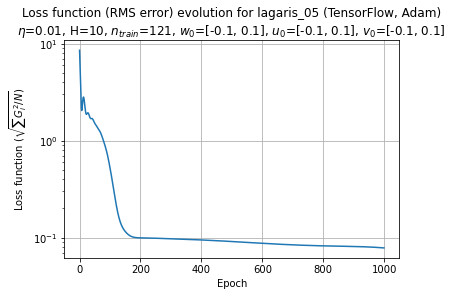

In [195]:
# Plot the loss function history.
plt.semilogy(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss function ($\sqrt {\sum G_i^2/N}$)")
plt.grid()
plt.title("Loss function (RMS error) evolution for %s (%s, %s)\n$\eta$=%s, H=%s, $n_{train}$=%s, $w_0$=%s, $u_0$=%s, $v_0$=%s" %
          (eq_name, 'TensorFlow', training_algorithm, learning_rate, H, n_train, w0_range, u0_range, v0_range))
plt.show()

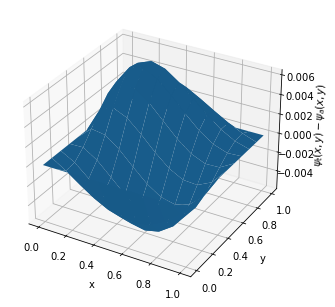

In [196]:
# For surface plotting, reshape as (n_x, n_y), then transpose.
Z = Yt_err_train.reshape((nx_train, ny_train)).T

# Plot the error in the trained solution at the training points.
fig = plt.figure()
(X, Y) = np.meshgrid(x_train, y_train)
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
ax.plot_surface(X, Y, Z)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('$\psi_t(x,y)-\psi_a(x,y)$')
plt.show()

In [ ]:
# For a Seaborn heat map, reshape as (n_x, n_y), then transpose, then flip.
Z = np.flip(Yt_err_train.reshape((nx_train, ny_train)).T, axis=0)
ax = sns.heatmap(Z, xticklabels=x_train, yticklabels=np.flip(y_train))

In [ ]:
# For a Matplotlib imshow plot, reshape as (n_x, n_y), then transpose, then flip.
Z = np.flip(Yt_err_train.reshape((nx_train, ny_train)).T, axis=0)
fig, ax = plt.subplots(1, 1)
values = ax.imshow(Z, extent=(0, 1, 0, 1))
fig.colorbar(values)
plt.show()

In [ ]:
# For surface plotting, reshape as (n_x, n_y), then transpose.
Z = dYt_dx_err_train.reshape((nx_train, ny_train)).T

# Plot the error in the trained 1st x-derivative at the training points.
fig = plt.figure()
(X, Y) = np.meshgrid(x_train, y_train)
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
ax.plot_surface(X, Y, Z)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('$\partial \psi_t(x,y)/\partial x-\partial \psi_a(x,y)/\partial x$')
plt.show()

In [ ]:
# For a Seaborn heat map, reshape as (n_x, n_y), then transpose, then flip.
Z = np.flip(dYt_dx_err_train.reshape((nx_train, ny_train)).T, axis=0)
ax = sns.heatmap(Z, xticklabels=x_train, yticklabels=np.flip(y_train))

In [ ]:
# For a Matplotlib imshow plot, reshape as (n_x, n_y), then transpose, then flip.
Z = np.flip(dYt_dx_err_train.reshape((nx_train, ny_train)).T, axis=0)
fig, ax = plt.subplots(1, 1)
values = ax.imshow(Z, extent=(0, 1, 0, 1))
fig.colorbar(values)
plt.show()

In [ ]:
# For surface plotting, reshape as (n_x, n_y), then transpose.
Z = dYt_dy_err_train.reshape((nx_train, ny_train)).T

# Plot the error in the trained 1st y-derivative at the training points.
fig = plt.figure()
(X, Y) = np.meshgrid(x_train, y_train)
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
ax.plot_surface(X, Y, Z)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('$\partial \psi_t(x,y)/\partial y-\partial \psi_a(x,y)/\partial y$')
plt.show()

In [ ]:
# For a Seaborn heat map, reshape as (n_x, n_y), then transpose, then flip.
Z = np.flip(dYt_dy_err_train.reshape((nx_train, ny_train)).T, axis=0)
ax = sns.heatmap(Z, xticklabels=x_train, yticklabels=np.flip(y_train))

In [ ]:
# For a Matplotlib imshow plot, reshape as (n_x, n_y), then transpose, then flip.
Z = np.flip(dYt_dy_err_train.reshape((nx_train, ny_train)).T, axis=0)
fig, ax = plt.subplots(1, 1)
values = ax.imshow(Z, extent=(0, 1, 0, 1))
fig.colorbar(values)
plt.show()

In [ ]:
# For surface plotting, reshape as (n_x, n_y), then transpose.
Z = d2Yt_dx2_err_train.reshape((nx_train, ny_train)).T

# Plot the error in the trained 2nd x-derivative at the training points.
fig = plt.figure()
(X, Y) = np.meshgrid(x_train, y_train)
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
ax.plot_surface(X, Y, Z)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('$\partial^2 \psi_t(x,y)/\partial x^2-\partial^2 \psi_a(x,y)/\partial x^2$')
plt.show()

In [ ]:
# For a Seaborn heat map, reshape as (n_x, n_y), then transpose, then flip.
Z = np.flip(d2Yt_dx2_err_train.reshape((nx_train, ny_train)).T, axis=0)
ax = sns.heatmap(Z, xticklabels=x_train, yticklabels=np.flip(y_train))

In [ ]:
# For a Matplotlib imshow plot, reshape as (n_x, n_y), then transpose, then flip.
Z = np.flip(d2Yt_dx2_err_train.reshape((nx_train, ny_train)).T, axis=0)
fig, ax = plt.subplots(1, 1)
values = ax.imshow(Z, extent=(0, 1, 0, 1))
fig.colorbar(values)
plt.show()

In [ ]:
# For surface plotting, reshape as (n_x, n_y), then transpose.
Z = d2Yt_dy2_err_train.reshape((nx_train, ny_train)).T

# Plot the error in the trained 2nd y-derivative at the training points.
fig = plt.figure()
(X, Y) = np.meshgrid(x_train, y_train)
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
ax.plot_surface(X, Y, Z)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('$\partial^2 \psi_t(x,y)/\partial x^2-\partial^2 \psi_a(x,y)/\partial x^2$')
plt.show()

In [ ]:
# For a Seaborn heat map, reshape as (n_x, n_y), then transpose, then flip.
Z = np.flip(d2Yt_dy2_err_train.reshape((nx_train, ny_train)).T, axis=0)
ax = sns.heatmap(Z, xticklabels=x_train, yticklabels=np.flip(y_train))

In [ ]:
# For a Matplotlib imshow plot, reshape as (n_x, n_y), then transpose, then flip.
Z = np.flip(d2Yt_dy2_err_train.reshape((nx_train, ny_train)).T, axis=0)
fig, ax = plt.subplots(1, 1)
values = ax.imshow(Z, extent=(0, 1, 0, 1))
fig.colorbar(values)
plt.show()

In [ ]:
# Plot the parameter histories for model 1.
phist = np.array(phist)
plt.figure(figsize=(12, 14))

# w
plt.subplot(311)
plt.plot(phist[:, 0:H])
plt.title("Hidden weight $w$")
plt.grid()

# u
plt.subplot(312)
plt.plot(phist[:, H:2*H])
plt.title("Hidden bias $u$")
plt.grid()

# v
plt.subplot(313)
plt.plot(phist[:, 2*H:3*H])
plt.title("Output weight $v$")
plt.grid()

plt.suptitle("Parameter evolution for model 1 %s (%s, %s)\n$\eta$=%s, H=%s, $n_t$=%s, $w_0$=%s, $u_0$=%s, $v_0$=%s" %
          (eq.name, 'TF', training_algorithm, learning_rate, H, n_train, w0_range, u0_range, v0_range))
plt.subplots_adjust(hspace=0.2)
plt.show()